# NewTalk News Crawl

This notebook demostrate how to crawl data from Yahoo News (https://tw.news.yahoo.com/).

However, it's incomplete. You'll have to use some advanced techniques to collect enough data for document classification.

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
req = requests.get('https://newtalk.tw')
req.encoding='utf-8'

In [3]:
soup = BeautifulSoup(req.text, 'lxml')

### Get categories of NewTalks

In [90]:
categories = []
for category in soup.select('.news-category-item'):
    
    print (category.a.attrs['href'])
    #print (soup)
    categories.append(category.a.attrs['href'])
    #print(category.attrs['href'])
len(categories)

https://newtalk.tw/news/category/1/%E6%94%BF%E6%B2%BB%E7%B6%93%E6%BF%9F
https://newtalk.tw/news/category/2/%E5%9C%8B%E9%9A%9B%E4%B8%AD%E5%9C%8B
https://newtalk.tw/news/category/3/%E7%94%9F%E6%B4%BB%E8%97%9D%E6%96%87
https://newtalk.tw/news/category/4/%E7%92%B0%E5%A2%83%E4%BA%BA%E6%AC%8A
https://newtalk.tw/news/category/5/%E7%A7%91%E6%8A%80%E9%9B%BB%E7%AB%B6
https://newtalk.tw/news/category/6/%E7%BE%8E%E9%A3%9F%E6%97%85%E9%81%8A
https://newtalk.tw/news/summary/today
https://newtalk.tw/news/topics/
https://newtalk.tw/opinion/list
https://newtalk.tw/opinion/uservoice
https://newtalk.tw/citizen/list
https://newtalk.tw/debate/list
https://newtalk.tw/videos
https://newtalk.tw/articles


14

remove unwanted categories

In [91]:
categories = categories[0:3]
categories

['https://newtalk.tw/news/category/1/%E6%94%BF%E6%B2%BB%E7%B6%93%E6%BF%9F',
 'https://newtalk.tw/news/category/2/%E5%9C%8B%E9%9A%9B%E4%B8%AD%E5%9C%8B',
 'https://newtalk.tw/news/category/3/%E7%94%9F%E6%B4%BB%E8%97%9D%E6%96%87']

#### 先跑兩個 def

In [104]:
def get_news_links(category):
    for i in range(1,2):
        
        #取range的頁數
        page_url = '{}{}{}'.format(category,"/",i)
        req = requests.get(page_url)
        soup = BeautifulSoup(req.text, 'lxml')

    return {article.attrs['href'] for article in soup.select(".news_title a")}

In [85]:
def get_new_content(url):
    content = []
    req = requests.get(url)
    req.encoding='utf-8'
    soup = BeautifulSoup(req.text, 'lxml')
    content.append(soup.select_one('div.content_title h1').text)
    content.append(soup.select_one('div.mainpic_text').text)
    for p in soup.select('div.fontsize.news-content p'):
        content.append(p.text)
    return '\n'.join(content)

### call func 跑迴圈換頁，印出content

In [113]:
#換頁後得到各篇文章的url
links = {}
article = []
for category in categories:
    links[category] = get_news_links(category)

for category in categories:
    for url in links[category]:
        article.append({'category':category, 'article':get_new_content(url)})

# 製造斷詞後的檔案

##### 以下這段不用RUN!

In [ ]:
from sklearn.datasets import load_files
news_data_folder = 'yahoonews_test'
# 手動把資料依照類別分別讀進來
dataset = load_files(news_data_folder,categories='world', shuffle=False)
dataset.target_names

In [ ]:
len(dataset.data)
#一個data是一篇文章，檢查有沒有存對

##### Jieba 斷詞。 

對，以下這段也不用RUN。

In [61]:
import jieba
jieba.set_dictionary('dict.txt.big.txt')

In [62]:
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

In [63]:
import string
# add more
stops.update(string.ascii_letters + string.punctuation + string.digits)
stops.update()
# and more self-defined stopwords
stops.update(map(lambda x: x.strip().split()[0], open('stopwords (1).txt')))

In [64]:
import io
i=0
news_words = []
for article in dataset.data:
    
    #依照各類別，把斷詞完的檔案寫進資料夾            
    out_filename = 'yahoonews_test_only3/world/world_'
    words = []
    keywords = []
    words.extend(list(jieba.cut(article)))
    keywords = [word for word in words if word not in stops]
    #print(keywords)
    news_words.append(' '.join(keywords))

    with io.open(out_filename+str(i), 'w', encoding = 'utf-8') as f:
        print(news_words[i], file = f)
        i=i+1
    
#dataset.data = news_words

Building prefix dict from /Users/Chiali/2017/碩二上修不完的三門課QQ/福仁文字探勘/Assignment/dict.txt.big.txt ...
Loading model from cache /var/folders/zc/sp3036hx3ps3pkrrlb4d7gkw0000gn/T/jieba.u43006043738a33ece19177c2fb6608ad.cache
Loading model cost 1.938 seconds.
Prefix dict has been built succesfully.


# Text Classification with SVM

In [9]:
from sklearn.datasets import load_files
dataset = load_files('newtalks_train', encoding='utf-8')
dataset.target_names

['International', 'Life', 'Politics']

In [10]:
len(dataset.data)
#一個data是一篇文章
print (dataset.data[0])

巴黎 槍擊 警察 一死 兩傷 　   恐攻 影響 首輪 投票 
 法國巴黎 香榭麗舍 大道 當地 時間 20 日 晚上 傳出 槍響 已 名 警察 死亡 兩名 警察 重傷 伊斯蘭 國 稍晚 宣稱 發動 此起 攻擊 法國 總統 歐蘭德 這是 恐怖 攻擊 呼籲 提高 警戒 總統大選 首輪 投票 
 法國巴黎 香榭麗舍 大道 當地 時間 20 日 晚上 傳出 槍響 一名 槍手 自動武器 一輛 巡邏 警車 開火 當場 一名 警察 死亡 兩名 警察 重傷 槍手 槍戰 中 趕到 警察 擊斃 
 路透社 報導 激進 組織 伊斯蘭 國 IS 稍晚 宣稱 發動 此起 攻擊 槍手 比利時人 尤賽夫 Abu   Yusuf   al Beljiki 一名 伊斯蘭 國 戰士 
 法國 內政部 發言人 指出 判定 犯案 動機 仍 言之過早 這起 槍擊 事件 警察 鎖定 對象 涉案者 不 排除 其他人 現場 警方 搜尋 另一名 潛在 嫌犯 
 23 日 法國 總統大選 第一輪 投票 此起 攻擊 事件 多位 總統 候選人 取消 競選活動 恐對 大選 影響 
   




# Extracting features from text files

### Tokenizing text with scikit-learn

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dataset.data)
X_train_counts.shape

(1500, 43782)

In [49]:
count_vect.vocabulary_.get("法國")

26494

In [32]:
ngram_count_vect = CountVectorizer(ngram_range=(1, 5))
XX_train_counts = ngram_count_vect.fit_transform(dataset.data)
XX_train_counts.shape

(1500, 1107910)

In [39]:
ngram_count_vect.vocabulary_.get("稍晚 宣稱")

795184

### From occurrences to frequencies

In [51]:
#沒有 ngram 的 tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1500, 43782)

In [52]:
#沒有 ngram 的 tfidf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1500, 43782)

In [67]:
#有 ngram 的 tf
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(XX_train_counts)
X_train_tf = tf_transformer.transform(XX_train_counts)
X_train_tf.shape

(1500, 1107910)

In [68]:
#有 ngram 的 tfidf
tfidf_transformer = TfidfTransformer()
XX_train_tfidf = tfidf_transformer.fit_transform(XX_train_counts)
XX_train_tfidf.shape

(1500, 1107910)

### TfidfVectorizer

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
XX_train_tfidf = tfidf_vectorizer.fit_transform(dataset.data)
X_train_tfidf.shape

(1500, 43782)

# Building a pipeline

In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier

TASK: Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent

In [55]:
from sklearn.pipeline import Pipeline
#SVM 
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import SGDClassifier

In [91]:
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC()),
])

In [92]:
text_clf.fit(dataset.data, dataset.target)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

## load test data

In [87]:
yahoo_test = load_files('yahoonews_test_only3', encoding='utf-8')

In [93]:
predicted = text_clf.predict(yahoo_test.data)

In [94]:
import numpy as np
np.mean(predicted == yahoo_test.target)

0.2623076923076923

In [95]:
from sklearn import metrics
print(metrics.classification_report(yahoo_test.target, predicted,
    target_names=yahoo_test.target_names))

             precision    recall  f1-score   support

  lifestyle       0.00      0.00      0.00       500
   politics       0.30      0.64      0.41       500
      world       0.17      0.08      0.10       300

avg / total       0.15      0.26      0.18      1300



### Parameter tuning using grid search

In [102]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__use_idf': (True, False),
              'clf__C': (1.0, 0.1, 1e-2, 1e-3),
#              'kernel':('linear', 'rbf'),
}

In [103]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [104]:
gs_clf = gs_clf.fit(dataset.data, dataset.target)

In [105]:
dataset.target_names[gs_clf.predict(['安全'])[0]]

'Life'

In [ ]:

iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
sorted(clf.cv_results_.keys())

In [106]:
gs_clf.best_score_

0.69599999999999995

In [107]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__C: 1.0
vect__ngram_range: (1, 2)
vect__use_idf: True


In [108]:
clf = gs_clf.best_estimator_

In [109]:
predicted = clf.predict(yahoo_test.data)

In [110]:
import numpy as np
np.mean(predicted == yahoo_test.target)  

0.23000000000000001

In [111]:
from sklearn import metrics
print(metrics.classification_report(yahoo_test.target, predicted,
    target_names=yahoo_test.target_names))

             precision    recall  f1-score   support

  lifestyle       0.00      0.00      0.00       500
   politics       0.28      0.55      0.37       500
      world       0.17      0.09      0.11       300

avg / total       0.14      0.23      0.17      1300



In [151]:
gs_clf.cv_results_

{'mean_fit_time': array([ 0.64932458,  0.60471892,  2.72940811,  2.49406012,  0.52689068,
         0.52608013,  3.19756262,  3.42056497,  0.93294803,  0.56863236,
         2.43908405,  2.9380761 ,  0.71114039,  0.6965944 ,  2.89947867,
         1.97009754]),
 'mean_score_time': array([ 0.20983307,  0.22278476,  0.4572893 ,  0.46047457,  0.18342098,
         0.18175522,  0.71240147,  0.58087866,  0.21662354,  0.19468562,
         0.53162456,  0.4990356 ,  0.23348331,  0.2131273 ,  0.54455956,
         0.36571622]),
 'mean_test_score': array([ 0.86733333,  0.872     ,  0.87466667,  0.87466667,  0.87      ,
         0.87      ,  0.874     ,  0.872     ,  0.86333333,  0.84666667,
         0.86866667,  0.85066667,  0.86866667,  0.85066667,  0.87066667,
         0.85466667]),
 'mean_train_score': array([ 0.99733366,  0.99733366,  0.998     ,  0.99733366,  0.96867127,
         0.94566922,  0.9856693 ,  0.95800391,  0.92500185,  0.89366412,
         0.95800791,  0.90199681,  0.93167119,  0.894

In [ ]:
cm = metrics.confusion_matrix(yahoo_test.data, predicted)
print(cm)

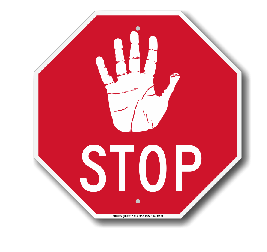

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('stop.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# 以下為草稿禁區，不用看！！！

### Get news list

In [6]:
req = requests.get('{}'.format(categories[0]))
soup = BeautifulSoup(req.text, 'lxml')

In [101]:
from urllib.parse import urljoin
urls = set()
for article in soup.select(".news_title a"):
    url = article.attrs['href']
    urls.add(url)
    #print(url)
    
len (urls)

20

#### Pack it into a function

In [104]:
def get_news_links(category):
    for i in range(1,2):
        
        #取range的頁數
        page_url = '{}{}{}'.format(category,"/",i)
        req = requests.get(page_url)
        soup = BeautifulSoup(req.text, 'lxml')

    return {article.attrs['href'] for article in soup.select(".news_title a")}

### Get links from every category

In [105]:
links = {}
for category in categories:
    links[category] = get_news_links(category)

In [ ]:
links

## Get news content

get the html document

In [79]:
req = requests.get('https://newtalk.tw/news/view/2017-05-16/86842')
req.encoding='utf-8'
soup = BeautifulSoup(req.text, 'lxml')

In [ ]:
print (soup)

In [83]:
soup.select_one('div.content_title h1').text

'流鶯MIKO二審將開庭\u3000日日春：檢察官狡辯硬坳'

In [ ]:
for p in soup.select('div.fontsize.news-content p'):
    print(p.text)

Pack it into a function

In [85]:
def get_new_content(url):
    content = []
    req = requests.get(url)
    req.encoding='utf-8'
    soup = BeautifulSoup(req.text, 'lxml')
    content.append(soup.select_one('div.content_title h1').text)
    content.append(soup.select_one('div.mainpic_text').text)
    for p in soup.select('div.fontsize.news-content p'):
        content.append(p.text)
    return '\n'.join(content)

In [86]:
url = 'https://newtalk.tw/news/view/2017-05-16/86844'
print(get_new_content(url))

黨產會追討10億  國民黨質疑先射箭再畫靶

        國民黨文傳會副主委洪孟楷與行管會主委邱大展今(16)日召開記者會表示，國民黨確實有取得政府財產，但那是因為政府欲賠償戰爭損失而給予的，且不只國民黨獲得。   圖: 國民黨部/提供      
近日黨產會調查國民黨早期透過「轉帳撥用」方式獲得國有土地，最快於月底將對此做出認定並處以行政處分，向國民黨追討高達十億元，國民黨文傳會副主委洪孟楷與行管會主委邱大展今(16)日召開記者會表示，國民黨確實有取得政府財產，但那是因為政府欲賠償戰爭損失而給予的，且不只國民黨獲得。
洪孟楷質疑，蔡英文是為了在520一周年前力求表現才對不當黨產開刀，將流於「先射箭再畫靶」的疑慮。洪孟楷強調，戰後補償是通例，黨產會今日只針對國民黨，就是針對性辦案、就是政黨惡鬥的工具。
邱大展說，當初為了統一黨政軍的指揮權，因而成立國防最高委員會，由國民黨總裁出任，依據相關會議記錄顯示，這些財產為政府欲彌補受日人戰爭影響遭受的損失，政府用轉帳方式將日產轉給黨部作為賠償戰爭損失。
邱大展還說，不只國民黨得到補償，其他如天津南開大學、青島美國學校、民社黨、上海市私立學校聯合會等皆取得日產作為補償。


news id parse function

In [11]:
import re
url_re = re.compile('-(\d{7,10})')

def parse_nid(url):
    m = url_re.search(url)
    return m.group(1)

In [63]:
parse_nid(url)

'125910139'

In [14]:
import os
for c in categories:
    os.mkdir(c)

In [ ]:
for category, urls in links.items():
    for url in urls:
        print(url)
        nid = parse_nid(url)
        filename = '{0}/{1}'.format(category, nid)
        
        if os.path.isfile(filename):
            continue

        content = get_new_content(url)
        with open(filename, 'w') as f:
            print(content, file=f)

## Use selenium

In [29]:
!pip install selenium

    100% |████████████████████████████████| 942kB 625kB/s ta 0:00:01


In [30]:
from selenium import webdriver
driver = webdriver.Chrome()

In [31]:
cat = categories[0]
driver.get('{}'.format(categories[0]))
cat

'https://newtalk.tw/news/category/1/%E6%94%BF%E6%B2%BB%E7%B6%93%E6%BF%9F'

In [18]:
urls = set()
for article in driver.find_elements_by_css_selector('.Cf a'):
    if article.text:
#         urls.add(article.text)
        urls.add(article.get_attribute('href'))
print(len(urls))

28


In [19]:
# used for: https://tw.news.yahoo.com/politics
for article in driver.find_elements_by_css_selector('div#mrt-node-Col1-1-Hero a'):
    if article.text:
#         urls.add(article.text)
        urls.add(article.get_attribute('href'))
print(len(urls))

28


In [204]:
import time
def get_urls(cat):
    driver.get('{}'.format(categories[0]))

    urls = set()
    for article in driver.find_elements_by_css_selector('.js-stream-content > div:not(.controller) a:not(.comment-btn-link)'):
        if article.text:
            urls.add(article.get_attribute('href'))
    for article in driver.find_elements_by_css_selector('div#mrt-node-Col1-1-Hero a'):
        if article.text:
            urls.add(article.get_attribute('href'))
    print(len(urls))
    return urls

In [189]:
len(links['politics'])

60